# Spatial Distribution of Rent-to-Income Ratios in Sydney Using Spatial Autocorrelation

In [14]:
# Required Libraries
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import libpysal
from esda.moran import Moran, Moran_Local
import matplotlib.patches as mpatches


In [15]:
# Load spatial data
spatial_data = gpd.read_file("data/SA1_rent_inc_v2.shp")
spatial_data

,id,SA1_CODE,median_ren,median_f_i,rent_inc_r,geometry
0,15803.0,12401144911,280.0,2150.0,0.130,"MULTIPOLYGON (((16729393.036 -3992556.161, 167..."
1,15870.0,12401145211,320.0,1674.0,0.191,"POLYGON ((16733116.671 -3992335.711, 16733115...."
2,15860.0,12401145201,340.0,1625.0,0.209,"POLYGON ((16732179.028 -3992550.808, 16732169...."
3,15869.0,12401145210,385.0,1792.0,0.215,"POLYGON ((16733725.39 -3990469.898, 16733891.5..."
4,15868.0,12401145209,385.0,1488.0,0.259,"POLYGON ((16733077.815 -3989999.635, 16733172...."
...,...,...,...,...,...,...
11198,18653.0,12702151316,330.0,1192.0,0.277,"POLYGON ((16802229.21 -4013814.242, 16802256.8..."
11199,18654.0,12702151317,290.0,1292.0,0.224,"POLYGON ((16802260.846 -4013451.192, 16802307...."
11200,18660.0,12702151323,340.0,1511.0,0.225,"POLYGON ((16802400.054 -4013647.271, 16802418...."
11201,18639.0,12702151302,410.0,1687.0,0.243,"POLYGON ((16801995.603 -4013495.012, 16802012...."


In [16]:
# Check for NA values
print(spatial_data['rent_inc_r'].isna().sum())

# Display rows with NA
print(spatial_data[spatial_data['rent_inc_r'].isna()].head())

# Convert NA to 0
spatial_data['rent_inc_r'].fillna(0, inplace=True)

# Verify NA values are replaced
print(spatial_data['rent_inc_r'].isna().sum())

278
          id     SA1_CODE  median_ren  median_f_i  rent_inc_r  \
75   15268.0  12302143629         0.0         0.0         NaN   
83   15288.0  12302143650         0.0         0.0         NaN   
125  15334.0  12302143752         0.0         0.0         NaN   
134  15325.0  12302143741         0.0         0.0         NaN   
195  15245.0  12302143602         0.0         0.0         NaN   

                                              geometry  
75   POLYGON ((16790220.332 -4042348.85, 16790201.4...  
83   POLYGON ((16790560.853 -4041540.921, 16790555....  
125  POLYGON ((16787008.404 -4038890.641, 16786993....  
134  POLYGON ((16787895.4 -4038895.067, 16787895.18...  
195  POLYGON ((16791905.816 -4039912.334, 16791894....  
0


C:\Users\140790\AppData\Local\Temp\ipykernel_12672\1925928690.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spatial_data['rent_inc_r'].fillna(0, inplace=True)


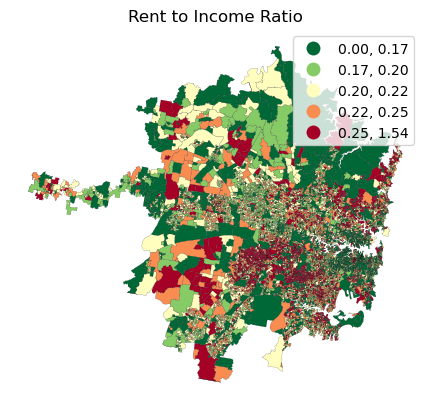

In [17]:
# Plot rent-to-income ratio
spatial_data.plot(column='rent_inc_r', scheme='quantiles', cmap='RdYlGn_r', legend=True,
                  edgecolor='black', linewidth=0.1)
plt.title("Rent to Income Ratio")
plt.axis('off')
plt.show()


In [18]:
# Spatial weights based on contiguity
w = libpysal.weights.Queen.from_dataframe(spatial_data)
w.transform = 'R'

# Global Moran's I
rent_to_inc_ratio = spatial_data['rent_inc_r'].values
global_moran = Moran(rent_to_inc_ratio, w)

print("Global Moran's I:", global_moran.I)
print("p-value:", global_moran.p_sim)


C:\Users\140790\AppData\Local\Temp\ipykernel_12672\2953875462.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(spatial_data)


Global Moran's I: 0.26472052935336843
p-value: 0.001


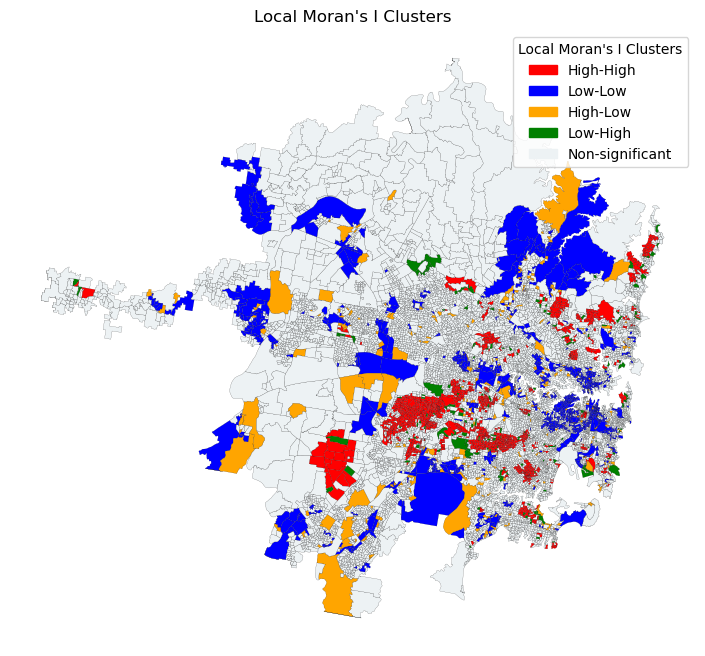

In [19]:
# Local Moran's I
local_moran = Moran_Local(rent_to_inc_ratio, w)

# Add Local Moran's I results to DataFrame
spatial_data['local_I'] = local_moran.Is
spatial_data['p_value'] = local_moran.p_sim

# Calculate mean for cluster classification
mean_value = rent_to_inc_ratio.mean()

# Define clusters based on significance and quadrant
sig = local_moran.p_sim <= 0.05

spatial_data['cluster'] = np.where(sig & (local_moran.q == 1), 'High-High',
                           np.where(sig & (local_moran.q == 2), 'Low-High',
                           np.where(sig & (local_moran.q == 3), 'Low-Low',
                           np.where(sig & (local_moran.q == 4), 'High-Low', 'Non-significant'))))

# Plot clusters
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'High-High': 'red', 'Low-Low': 'blue', 'High-Low': 'orange', 'Low-High': 'green', 'Non-significant': '#edf2f4'}
spatial_data['color'] = spatial_data['cluster'].map(colors)
spatial_data.plot(color=spatial_data['color'], edgecolor='black', linewidth=0.1, ax=ax)

# Creating legend manually
patches = [mpatches.Patch(color=color, label=cluster) for cluster, color in colors.items()]
plt.legend(handles=patches, title="Local Moran's I Clusters", loc='best')

plt.title("Local Moran's I Clusters")
plt.axis('off')
plt.show()


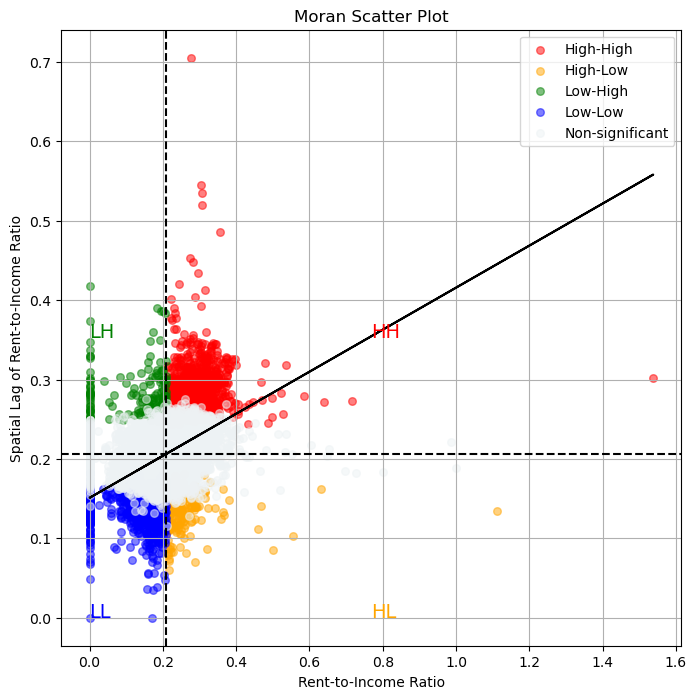

In [20]:
# Spatial lag (average of neighboring values)
spatial_data['spatial_lag'] = libpysal.weights.lag_spatial(w, rent_to_inc_ratio)

# Moran Scatter Plot
fig, ax = plt.subplots(figsize=(8, 8))

for cluster, data in spatial_data.groupby('cluster'):
    ax.scatter(data['rent_inc_r'], data['spatial_lag'], 
               label=cluster, alpha=0.5, color=colors[cluster], s=30)

# Add regression line
m, b = np.polyfit(spatial_data['rent_inc_r'], spatial_data['spatial_lag'], 1)
ax.plot(spatial_data['rent_inc_r'], m * spatial_data['rent_inc_r'] + b, color='black')

# Mean lines
plt.axvline(mean_value, linestyle='--', color='black')
plt.axhline(spatial_data['spatial_lag'].mean(), linestyle='--', color='black')

# Annotate quadrants
plt.text(spatial_data['rent_inc_r'].max()/2, spatial_data['spatial_lag'].max()/2, "HH", color="red", fontsize=14)
plt.text(spatial_data['rent_inc_r'].min()/2, spatial_data['spatial_lag'].max()/2, "LH", color="green", fontsize=14)
plt.text(spatial_data['rent_inc_r'].max()/2, spatial_data['spatial_lag'].min()/2, "HL", color="orange", fontsize=14)
plt.text(spatial_data['rent_inc_r'].min()/2, spatial_data['spatial_lag'].min()/2, "LL", color="blue", fontsize=14)

plt.xlabel("Rent-to-Income Ratio")
plt.ylabel("Spatial Lag of Rent-to-Income Ratio")
plt.title("Moran Scatter Plot")
plt.legend()
plt.grid(True)
plt.show()
